In [1]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d,lib.cnmem=0"%(random.randint(0,3))
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge, Conv2D
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import cPickle, random, sys, keras
from keras.models import Model
from IPython import display

sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# Load data

## LiDAR

In [3]:
data_len = 1000

In [4]:
lidar_path = '../../../../research_data/datasets/kitti/kitti-yolo-100m-res-0.1/npy'
data = np.load(lidar_path + '/outfile_9999.npy')
import os


'''
for root, dirs, files in os.walk(lidar_path):
    for file in files:        
        if file.endswith((".npy")):
            print file
'''

files = sorted(os.listdir(lidar_path))
lidar_data = []
i = 0
for file in files:
    if file.endswith((".npy")):
        data = np.load(lidar_path + '/' + file)
        data = data.astype(np.float64)
        lidar_data.append(data)
        i+=1
        if(i==data_len):
            break
lidar_data = np.array(lidar_data)        
# Add the channel dim
lidar_data = np.expand_dims(lidar_data, axis=1)

In [5]:
lidar_data.shape

(1000, 1, 1000, 300)

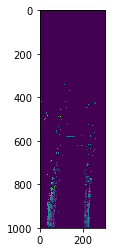

In [8]:
plt.imshow(lidar_data[5,0,:,:])

## Camera

In [ ]:

import matplotlib.image as mpimg
path_to_file = '../../../../research_data/datasets/kitti/rgb_images'
img = '5.png'
plt.imshow(mpimg.imread(path_to_file + '/' + img))

In [ ]:
i = mpimg.imread(path_to_file + '/' + img)

In [ ]:
i.shape

In [ ]:
plt.imshow(i)

In [ ]:
'''
from PIL import Image
path_to_file = '../../../datasets/kitti/rgb_images'
im_frame = Image.open(path_to_file + '/0.png')
np_frame = np.array(im_frame.getdata())
'''

In [6]:

import matplotlib.image as mpimg
camera_path = '../../../../research_data/datasets/kitti/rgb_images'
files = sorted(os.listdir(camera_path))
camera_data = []
i = 0
for file in files:
    if file.endswith((".png")):        
        #im_frame = Image.open(camera_path + '/' + file)
        im_frame = mpimg.imread(camera_path + '/' + file)
        im_frame /= 255
        camera_data.append(im_frame)
        i+=1
        if(i==data_len):
            break
camera_data = np.array(camera_data) 
# Make channel first
camera_data = np.array(np.transpose(camera_data, (0, 3, 1, 2)))

(375, 1242, 3)


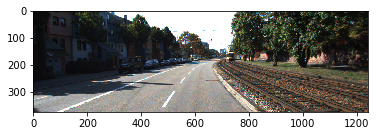

In [10]:
im = np.array(np.transpose(camera_data[0], (1,2,0)))
print(im.shape)
plt.imshow(im*255)

In [7]:
camera_data.shape

(1000, 3, 375, 1242)

In [ ]:
'''
dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
# Build Generative model ...
nch = 2
#(img_L, img_W) = df['images'][0].shape
(ch, lidar_img_L, lidar_img_W) = lidar_data.shape[1:]
flat_img_size = camera_data.shape[1]*camera_data.shape[2]*camera_data.shape[3]
g_input = Input(shape=[flat_img_size])
#g_input = Input(shape=camera_data.shape[1:])
#H = Flatten()(g_input)
#H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(H)
H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, lidar_img_L/2, lidar_img_W/2] )(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(nch/4, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()
'''

In [ ]:
'''
dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
# Build Generative model ...
nch = 2
#(img_L, img_W) = df['images'][0].shape
(ch, lidar_img_L, lidar_img_W) = lidar_data.shape[1:]
flat_img_size = camera_data.shape[1]*camera_data.shape[2]*camera_data.shape[3]
#g_input = Input(shape=[flat_img_size])
g_input = Input(shape=camera_data.shape[1:])
print(g_input.shape)
H = Flatten()(g_input)
print(H.shape)
#H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(H)
H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, lidar_img_L/2, lidar_img_W/2] )(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(nch/4, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()
'''

In [ ]:
'''
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

# First, define the vision modules
digit_input = Input(shape=(27, 27, 1))
x = Conv2D(64, (3, 3))(digit_input)
print(x.shape)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)
out = Reshape( [11, 11, 64] )(out)
print(out.shape)

vision_model = Model(digit_input, out)
print(vision_model.summary())

# Then define the tell-digits-apart model
digit_a = Input(shape=(27, 27, 1))
digit_b = Input(shape=(27, 27, 1))

# The vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = keras.layers.concatenate([out_a, out_b])
out = Dense(1, activation='sigmoid')(concatenated)

classification_model = Model([digit_a, digit_b], out)
print(classification_model.summary())
'''

In [ ]:
'''
dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
# Build Generative model ...
nch = 4
#(img_L, img_W) = df['images'][0].shape
(ch, lidar_img_L, lidar_img_W) = lidar_data.shape[1:]
flat_img_size = camera_data.shape[1]*camera_data.shape[2]*camera_data.shape[3]


g_input = Input(shape=camera_data.shape[1:])
print(g_input.shape)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(g_input)
print(H.shape)
H = Flatten()(H)
print(H.shape)
H = Dense(lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [1, lidar_img_L/2, lidar_img_W/2] )(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(nch/4, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()
'''

In [8]:

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
# Build Generative model ...
nch = 4
#(img_L, img_W) = df['images'][0].shape
(ch, lidar_img_L, lidar_img_W) = lidar_data.shape[1:]
flat_img_size = camera_data.shape[1]*camera_data.shape[2]*camera_data.shape[3]


g_input = Input(shape=camera_data.shape[1:])
#Encoder
H = Conv2D(nch, (3, 3), data_format='channels_first', border_mode='valid', init='glorot_uniform')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='valid', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='valid', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
'''
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='valid', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
'''
# Decoder
H = Flatten()(H)
H = Dense(lidar_img_L/4*lidar_img_W/4, init='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [1, lidar_img_L/4, lidar_img_W/4] )(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first")`
  app.launch_new_instance()
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="valid", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (3, 3), padding="valid", kernel_initializer="glorot_uniform", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="valid", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykern

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 375, 1242)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 373, 1240)      112       
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 373, 1240)      4960      
_________________________________________________________________
activation_8 (Activation)    (None, 4, 373, 1240)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 186, 620)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 184, 618)       74        
_________________________________________________________________
batch_normalization_8 (Batch (None, 2, 184, 618)       2472      
__________

/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), padding="same", kernel_initializer="glorot_uniform", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform", data_format="channels_first")`


In [13]:
#input_img = np.reshape(camera_data[0:2], [2, flat_img_size])
input_img = camera_data
generated_lidar = generator.predict(input_img)

KeyboardInterrupt: 

In [ ]:
generated_lidar.shape

# Combine both LiDAR and Images

In [7]:
import pandas as pd
camera_data = list(camera_data)
lidar_data = list(lidar_data)

df = pd.DataFrame({'images':camera_data, 'lidar':lidar_data})

## Train/test data

In [8]:
from sklearn.model_selection import train_test_split
random_state = 42
test_size = 0.1
# the data, shuffled and split between train and test sets

(X_train, X_test) = train_test_split(df, test_size=test_size, random_state=random_state, shuffle=True)


# GAN

In [9]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [ ]:
'''
#shp = X_train.shape[1:]
#print shp

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
#opt = Adam(lr=1e-3)
#opt = Adamax(lr=1e-4)
#opt = Adam(lr=0.0002)
#opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)


# Build Generative model ...
nch = 20
#(img_L, img_W) = df['images'][0].shape
(ch, lidar_img_L, lidar_img_W) = df['lidar'][0].shape
flat_img_size = df['images'][0].shape[0]*df['images'][0].shape[1]*df['images'][0].shape[2]
g_input = Input(shape=[flat_img_size])
#H = Flatten()(g_input)
#H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(H)
H = Dense(nch*lidar_img_L/2*lidar_img_W/2, init='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, lidar_img_L/2, lidar_img_W/2] )(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(nch/4, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=df['lidar'][0].shape)
#d_input = Input(shape=(1, df['lidar'][0].shape[0], df['lidar'][0].shape[1]))

#H = keras.backend.expand_dims(d_input, axis=1)
#print(H.shape)
H = Conv2D(256, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(512, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)
# Build stacked GAN model
#gan_input = Input(shape=df['images'][0].shape)
gan_input = Input(shape=[flat_img_size])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()
'''


In [10]:

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-3)
dopt = Adam(lr=1e-4)
# Build Generative model ...
nch = 4
#(img_L, img_W) = df['images'][0].shape
(ch, lidar_img_L, lidar_img_W) = df['lidar'][0].shape

g_input = Input(shape=df['images'][0].shape)
#Encoder
H = Conv2D(nch, (3, 3), data_format='channels_first', subsample=(2, 2), border_mode='valid', init='glorot_uniform')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', subsample=(2, 2), border_mode='valid', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
'''
H = Conv2D(nch/2, (3, 3), data_format='channels_first', subsample=(2, 2), border_mode='valid', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)

H = Conv2D(nch/2, (3, 3), data_format='channels_first', subsample=(2, 2), border_mode='valid', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
'''

# Decoder
H = Flatten()(H)
H = Dense(lidar_img_L/4*lidar_img_W/4, init='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [1, lidar_img_L/4, lidar_img_W/4] )(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch/2, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = UpSampling2D(size=(2, 2), data_format='channels_first')(H)
H = Conv2D(nch, (3, 3), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Conv2D(1, (1, 1), data_format='channels_first', border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=df['lidar'][0].shape)
#d_input = Input(shape=(1, df['lidar'][0].shape[0], df['lidar'][0].shape[1]))

#H = keras.backend.expand_dims(d_input, axis=1)
#print(H.shape)
H = Conv2D(8, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(8, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(8, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(256, (5, 5), data_format='channels_first', subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = MaxPooling2D((2,2), data_format='channels_first', border_mode='valid')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=df['images'][0].shape)
#gan_input = Input(shape=[flat_img_size])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()


/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), kernel_initializer="glorot_uniform", data_format="channels_first", padding="valid", strides=(2, 2))`
  
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="valid", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (3, 3), kernel_initializer="glorot_uniform", data_format="channels_first", padding="valid", strides=(2, 2))`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="valid", data_format="channels_first")`
/root/anaconda3/envs/DL2/lib/python2.7/site-packages/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 375, 1242)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 187, 620)       112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 187, 620)       2480      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 187, 620)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 93, 310)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 46, 154)        74        
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 46, 154)        616       
__________

In [11]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [12]:
def plot_gen(img, lidar, n_ex=12,dim=(4,3), figsize=(10,10) ):

    generated_lidar = generator.predict(img)
    img = np.array(np.transpose(img, (0, 2, 3, 1)))    
    plt.figure(figsize=figsize)
    
    #for i in range(generated_lidar.shape[0]):
    for i in range(2):
        plt.subplot(dim[0],dim[1],i*3+1)        
        plt.imshow(img[i,:,:,:]*255)
                         
        
        plt.subplot(dim[0],dim[1],i*3+2)
        plt.imshow(lidar[i,0,:,:])
        
        plt.subplot(dim[0],dim[1],i*3+3)
        lidar_img = generated_lidar[i,0,:,:]
        plt.imshow(lidar_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
#train_imgs = np.stack(np.array(X_train['images']).flat)

In [ ]:
#train_imgs.shape

In [ ]:
#images_gen = np.reshape(train_imgs, [train_imgs.shape[0], train_imgs.shape[1]*train_imgs.shape[2]*train_imgs.shape[3]])

In [ ]:
#images_gen.shape

In [ ]:
#ntrain = 900
#trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
#XT = X_train

# Pre-train the discriminator network ...
#noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
BATCH_SIZE = 2
n_epochs = 10
#XT = X_train.sample(n=BATCH_SIZE, random_state=random_state)
#print(XT.shape)
train_imgs = np.stack(np.array(X_train['images']).flat)
#images_gen = np.array(np.transpose(train_imgs, (0, 3, 1, 2)))

#images_gen = np.reshape(train_imgs, [train_imgs.shape[0], train_imgs.shape[1]*train_imgs.shape[2]*train_imgs.shape[3]])
images_gen = train_imgs
#print(images_gen.shape)
train_lidar = np.stack(np.array(X_train['lidar']).flat)
#train_lidar = np.expand_dims(train_lidar, axis=1)
#generator.fit(images_gen, train_lidar, nb_epoch=100, batch_size=BATCH_SIZE)
generated_lidar = generator.predict(images_gen)

#print(train_lidar.shape)
X = np.concatenate((train_lidar, generated_lidar))
n = X_train.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=n_epochs, batch_size=BATCH_SIZE)
y_hat = discriminator.predict(X)
make_trainable(discriminator,False)
y2 = np.zeros([len(images_gen),2])
y2[:,1] = 1
GAN.fit(images_gen, y2,nb_epoch=n_epochs, batch_size=BATCH_SIZE)


In [ ]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)

In [13]:
# set up loss storage vector
losses = {"d":[], "g":[]}

In [14]:
make_trainable(discriminator,True)

In [15]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        #XT = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE)]    
        XT = X_train.sample(n=BATCH_SIZE, random_state=np.random.randint(nb_epoch))
        #lidar_batch = np.array(XT['lidar'])
        train_lidar = np.stack(np.array(XT['lidar']).flat)
        #noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        #images_gen = np.array(XT['images'])
        train_imgs = np.stack(np.array(XT['images']).flat)
        #images_gen = np.array(np.transpose(train_imgs, (0, 3, 1, 2)))# Channels first
        #generator.train_on_batch(images_gen, train_lidar, nb_epoch=100, batch_size=BATCH_SIZE)
    
        generated_lidar = generator.predict(train_imgs)
        
        #generator.train_on_batch(train_imgs, train_lidar)
        
        # Train discriminator on generated images
        X = np.concatenate((train_lidar, generated_lidar))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        #noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(train_imgs, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            #plot_gen(train_imgs, train_lidar)
            plot_gen(train_imgs, train_lidar)
        

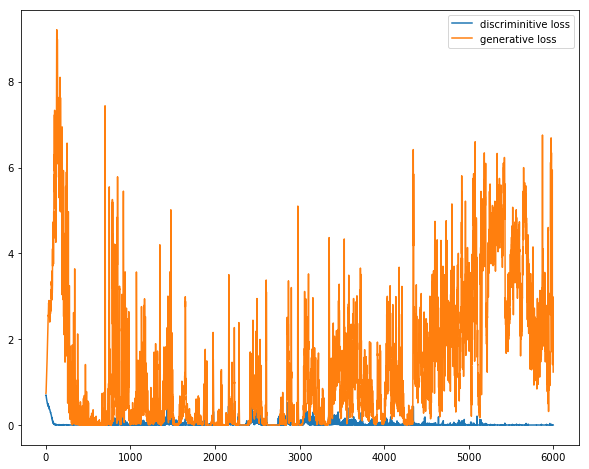

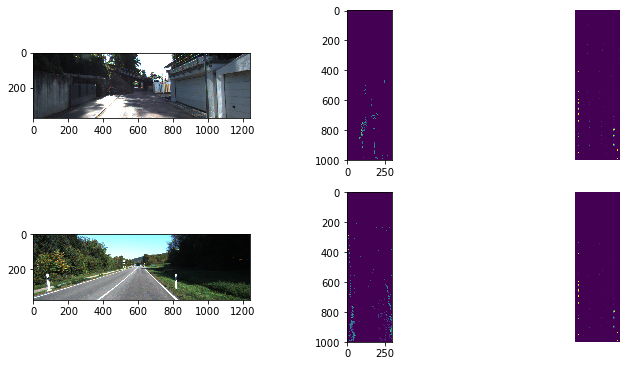

100%|██████████| 6000/6000 [1:46:43<00:00,  1.75s/it]


In [16]:
train_for_n(nb_epoch=6000, plt_frq=24,BATCH_SIZE=10)

In [ ]:
opt.lr= 1e-5
dopt.lr = 1e-4
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=32)

In [ ]:
opt.lr = 1e-6
dopt.lr = 1e-5
train_for_n(nb_epoch=2000, plt_frq=25,BATCH_SIZE=32)

In [ ]:
plot_loss(losses)

In [ ]:
plot_gen(25,(5,5),(12,12))

In [ ]:
def plot_real(n_ex=16,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [ ]:
plot_real()